In [3]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 248 kB 41.6 MB/s 
     |████████████████████████████████| 140 kB 57.2 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [4]:
# imports
import pickle
import json
import pandas as pd

import networkx as nx
from community import community_louvain
import fa2

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import random

import re

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import os
from IPython.display import clear_output 

save=False

We are using a subset of the [**#nowplaying**](https://dbis.uibk.ac.at/sites/default/files/2017-03/wissm03-zangerle.pdf) dataset. The #nowplaying dataset includes tracks which have been tweeted using the hashtags #nowplaying, #listento or #listeningto. 

The dataset which we are going to use holds users, their playlists and the tracks contained in these playlists. Our interest is just in the tracks what a particular user is listening to, so during the preprocesing phase, the `playlistname` column will be removed.

In [2]:
spotify_df = pd.read_csv('/content/drive/MyDrive/SocialGraphs/Spotify_data/spotify_dataset.csv', 
                         skiprows=1,
                         names=['user_id', 'artistname', 'trackname', 'playlistname'],
                         on_bad_lines='skip')
# drop column with NaN
spotify_df = spotify_df.dropna()
# remove playlist column
spotify_df = spotify_df.drop(columns=['playlistname'])
# some titles contain only numbers, we force everything to be a string
spotify_df["trackname"] = spotify_df.trackname.apply(str)
# # remove a user's duplicate tracks
spotify_df = spotify_df.drop_duplicates()

print("Initial datase set size:", len(spotify_df))
spotify_df.head()

Initial datase set size: 11382151


,user_id,artistname,trackname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders..."
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison


The `artistname` column contains the artist’s name extracted from the tweets with minimal preprocessing. Therefore, we should validate the column by checking if the values correspond to a single or multiple artists since a song can be performed by a single artist, multiple artists, or groups. 

We start with computing a set with all values of the `artistname`.

In [4]:
# generate initial artists set
artists_set = set(map(lambda artist: str(artist).lower(), spotify_df.artistname))
len(artists_set)

282520

The dataset contains 282520 unique values for the `artistname`. Now, we want to check how many of these values correspond to a single artist or it is about a collaboration. 

One problem with the dataset is how the names of artists who collaborated on the same song are delimited. Since there is not a standard deminitation, we split the `artistiname` using multiple delimitators: "&", ",",  "/", "and", "feat.", "ft.", "featuring", "with" and check if it is a true collaboration and not the name of an artistic group.

In [5]:
# split artistname using multiple separators:
sep = '( and | & |, | \/ | feat. | feat | ft. | f. | featuring | with | - |; )'
spotify_df["artistname"] = spotify_df["artistname"].apply(lambda artistname: re.split(sep, str(artistname).lower()))
spotify_df["artistname"] = spotify_df["artistname"].apply(lambda artistname: list((set(artistname) & (artists_set))) if (set(artistname) & (artists_set)) else artistname)

In [6]:
spotify_df.head(1)

,user_id,artistname,trackname
0,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],(The Angels Wanna Wear My) Red Shoes


Now, the `artistname` column is a list, where each entry of the list is the name of the artist performing the song. Since some tracks can have the same name but be performed by different artists, we'll create a new column `tracks`, were we combine the `artistname` and `trackname` columns. Now, we can compute the tracks frequency, which will be very important when we'll create the **users network**.

In [29]:
# we want `artistname` to be hashable, hence we use a frozenset
spotify_df.artistname = spotify_df.artistname.apply(frozenset)
# since multiple tracks can have the same name, it is essential to create a new entry
# in `spotify_df`, where we combine the track's name with the performing artist
spotify_df["tracks"] = list(zip(spotify_df['trackname'], spotify_df['artistname']))
# compute the tracks frequency and save it into spotify_df
spotify_df["tracks_freq"] = spotify_df.groupby(['tracks'])['tracks'].transform('count')

In [7]:
# update artists set
artists_set = set([artist for artists in spotify_df.artistname for artist in artists])
print("The number of unique artists in the dataset:", len(artists_set))

The number of unique artists in the dataset: 247580


Even after extracting the collaborations, the number of artists is still far too high. An explanation for this phenomenon is the ease of releasing new songs. Nowadays, it is within anyone's reach to release a new track, and that track doesn't need to be popular. 

To reduce the number of artists to have more concluded results, we filtered artists based on their `popularity`, whereby popularity means the number of occurrences in the dataset.

In [8]:
# compute number of occurancies
popularity = Counter(x for xs in spotify_df.artistname for x in set(xs))

In [9]:
# top 5 most popular artists
print("Top 5 most popular artists:")
for a, p in popularity.most_common(5):
    print(a, "-", p)

Top 5 most popular artists:
daft punk - 31446
coldplay - 30422
radiohead - 27566
the rolling stones - 27134
eminem - 25849


The 5 most popular artists in the dataset correspond to some of the biggest names in the music industry of all time. On the other hand, if we analyzed the artists with a single occurances, they are some names we have not heard of:

In [10]:
# top 5 least popular artists
print("Top 5 least popular artists:")
for a, p in popularity.most_common()[-5:]:
    print(a, "-", p)

Top 5 least popular artists:
kavita krishnamurthy subrahmaniam - 1
anuj mathews - 1
pathik - 1
so so desi - 1
cedric gervais starring mya - 1


Display popularity distribution

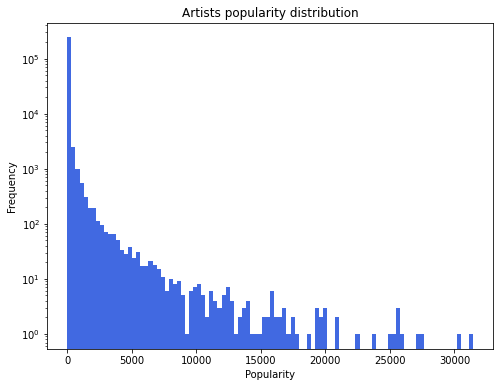

In [11]:
_pvalues = list(popularity.values())
fig, ax = plt.subplots(figsize=(8,6))

plt.title('Artists popularity distribution')
ax.hist(_pvalues, bins=100, color='royalblue', log=True)
ax.set_xlabel("Popularity")
ax.set_ylabel("Frequency")
plt.show()


The distribution is tail-heavy, there are a lot of artists that don't appear very frequently in the dataset. To counteract this skewness, we have opted to remove artists that appear in the dataset 50 times or less.

In [12]:
# spotify_df.to_pickle(r'/content/drive/MyDrive/SocialGraphs/spotify_dataset_small.pickle') 

In [13]:
artists_set = set([key for key, val in popularity.items() if val > 50])

In [14]:
# drop rows with artists which are not in `artists_set`
spotify_df = spotify_df[list(map(lambda artistname: set(artistname).issubset(artists_set), spotify_df.artistname))]

## Building the artists network

In [15]:
import networkx as nx
# build th artist network
artists_graph = nx.Graph()
# use the artists as nodes
artists_graph.add_nodes_from(artists_set)


We extract collaborations from the Spotify dataset, where a collaboration only exists if there are multiple artist list entries associated with each track.

In [16]:
collaborations = spotify_df.loc[map(lambda artists: len(artists) > 1, spotify_df.artistname)][["artistname"]]
print("Number of collaborations in dataset:", len(collaborations))

Number of collaborations in dataset: 280047


We connect each artist according to their collaborations.

In [17]:
artists_edges = list(map(lambda a: [(a[i], a[j]) for i in range(0, len(a) - 1) for j in range(i + 1, len(a))],\
                        collaborations.artistname))
artists_edges = [j for i in artists_edges for j in i]

In [18]:
artists_graph.add_edges_from(artists_edges)

### Artists' collaboration network

The next step is to remove the isolated nodes (the artists without collaborations) and extracted the largest connected component.

In [19]:
artists_graph.remove_nodes_from(list(nx.isolates(artists_graph)))
Gcc = sorted(nx.connected_components(artists_graph), key=len, reverse=True)
artists_graph = artists_graph.subgraph(Gcc[0])

print("Number of nodes:", artists_graph.number_of_nodes())
print("Number of edges:", artists_graph.number_of_edges())

Number of nodes: 4580
Number of edges: 9830


Once we have the largest component connected, we can remove the entries in the dataset corresponding to artists that are not a node.

In [20]:
# update the artists_set
artists_set = set(artists_graph.nodes())
# drop rows with artists which are not a node
spotify_df = spotify_df[list(map(lambda artistname: set(artistname).issubset(artists_set), spotify_df.artistname))]

# if save == True:
#     spotify_df.to_pickle(r'/content/drive/MyDrive/SocialGraphs/spotify_dataset_preprocessed.pickle')

#### Get information from Spotify API

Using the Spotify Api we intend to create an `artists dataset`, where tot keep information about the artist, they spotify id, their spotify popularity, their musical genres and related artists.

In [25]:
artists_set = set(artists_graph.nodes())
data = {'artistname': list(artists_set),
        'id': [None] * len(artists_set),
        'popularity': [None] * len(artists_set),
        'genres': [None] * len(artists_set),
        'related_artists': [None] * len(artists_set)}
artists_df = pd.DataFrame(data)

# if save == True:
#     artists_df.to_pickle(r'/content/drive/MyDrive/SocialGraphs/artists_dataset.pickle')

In [26]:
# load credentials
credentials = json.load(open('authorization.json'))
client_id = credentials['client_id']
client_secret = credentials['client_secret']

In [27]:
def search_artist_spotify(artist):
    results = sp.search(q=artist.artistname, type='artist')
    match = []

    for result in results['artists']['items']:
        # check if artist was found
        if result['name'].lower() == artist.artistname:
            match.append(result)
        # if multiple matches has been found, keep the most popular one
        if len(match) >= 1:
            match = sorted(match, key = lambda i: i["popularity"], reverse=True)

            artist.id = match[0]["id"]
            artist.popularity = match[0]["popularity"]
            artist.genres = match[0]["genres"]
    
    return artist

In [28]:
def get_related_artists_spotify(artist):
    results = sp.artist_related_artists(artist.id)
    related_artists=list()
    for result in results['artists']:
        if result['name'].lower() in set(artists_df.artistname):
            related_artists.append(result['name'].lower())
    artist.related_artists = related_artists

In [29]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret,
    ))

i = 0
for _, artist in artists_df.iterrows():
    if i % 100 == 0:
        # os.system('clear')
        clear_output()
        print(i, "/", len(artists_df))
    i += 1
    artist = search_artist_spotify(artist)

4500 / 4580


In [30]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret,
    ), requests_timeout=10, retries=10)

i = 0
for _, artist in artists_df.iterrows():
    if i % 100 == 0:
        # os.system('clear')
        clear_output()
        print(i, "/", len(artists_df))
    i += 1
    if artist.id != None:
        get_related_artists_spotify(artist)

4500 / 4580


In [33]:
artists_df.head()

,artistname,id,popularity,genres,related_artists
0,z-trip,0YUefH6Li1IsJBtlUWgtwc,33,[turntablism],"[cut chemist, lyrics born, x-ecutioners, black..."
1,canton jones,3nzEXHMRFWTw4zt3pVRv6V,36,"[christian hip hop, gospel]","[james fortune, kierra sheard, fred hammond]"
2,drums,None,None,None,None
3,meshell ndegeocello,0uZRjholJ0fVC2J9EvnYnj,46,[neo soul],"[les nubians, raphael saadiq, jill scott, leel..."
4,birdy,2WX2uTcsvV5OnS0inACecP,70,[pop],"[gabrielle aplin, emeli sandé, ella eyre]"


We need to check how many artists have not been returned by Spotify API, and remove them from `artists_graph` and `spotify_df`.

In [36]:
no_info = (list(artists_df[artists_df.id.isnull()].artistname) + list(artists_df[artists_df.genres.isnull()].artistname))
print("Number of artists which haven't been returned by Spotify API:", len(no_info))

Number of artists which haven't been returned by Spotify API: 398


In [37]:
artists_graph = nx.Graph(artists_graph) # unfreeze the graph
artists_graph.remove_nodes_from(list(no_info))
Gcc = sorted(nx.connected_components(artists_graph), key=len, reverse=True)
artists_graph = artists_graph.subgraph(Gcc[0])

print("number of nodes:", artists_graph.number_of_nodes())
print("number of edges:", artists_graph.number_of_edges())

number of nodes: 4238
number of edges: 9067


The final artists' collaboration graphs generated based on the `#nowplaying` dataset has the 4238 nodes and 9067 edges.

In [38]:
# update the artists_set
artists_set = set(artists_graph.nodes())
# # remove artists from spotify_df
spotify_df = spotify_df[list(map(lambda artistname: set(artistname).issubset(artists_set), spotify_df.artistname))]

In [15]:
# update the artists_df
artists_df = artists_df[~(artists_df.id.isnull()) & ~(artists_df.genres.isnull())]

In [16]:
# artists_df.to_pickle(r'/content/drive/MyDrive/SocialGraphs/artists_dataset.pickle')

In [17]:
artists_df = pd.read_pickle(r'/content/drive/MyDrive/SocialGraphs/artists_dataset.pickle')

We should append information about the genres to each track from `spotify_df`

In [40]:
def get_genre(artists):
    genres = []
    for artist in artists:
        genres += artists_df.loc[artist].genres
    return genres

artists_df.set_index("artistname", inplace=True)
spotify_df["genre"] = list(map(get_genre, spotify_df.artistname))
artists_df.reset_index(inplace=True)

In [31]:
spotify_df.head(1)

,user_id,artistname,trackname,genre,tracks
0,9cc0cfd4d7d7885102480dd99e7a90d6,(elvis costello),(The Angels Wanna Wear My) Red Shoes,"[art rock, folk, folk rock, mellow gold, new w...","((The Angels Wanna Wear My) Red Shoes, (elvis ..."


In [35]:
# spotify_df.to_pickle(r'/content/drive/MyDrive/SocialGraphs/spotify_dataset_processed.pickle')

In [36]:
spotify_df = pd.read_pickle(r'/content/drive/MyDrive/SocialGraphs/spotify_dataset_processed.pickle')

#### Spotify artists network

##### Generate network

In [25]:
# construct artist network
sp_artists_graph = nx.Graph()
sp_artists_graph.add_nodes_from(artists_set)

In [21]:
sp_artists_edges = list(map(lambda a, ras: [(a, ra) for ra in ras],
                            artists_df[~artists_df.related_artists.isnull()].artistname,
                            artists_df[~artists_df.related_artists.isnull()].related_artists))
sp_artists_edges = [j for i in sp_artists_edges for j in i]

In [26]:
sp_artists_graph.add_edges_from(sp_artists_edges)
sp_artists_graph.remove_nodes_from(list(nx.isolates(sp_artists_graph)))
Gcc = sorted(nx.connected_components(sp_artists_graph), key=len, reverse=True)
sp_artists_graph = sp_artists_graph.subgraph(Gcc[0])

print("number of nodes:", sp_artists_graph.number_of_nodes())
print("number of edges:", sp_artists_graph.number_of_edges())

number of nodes: 3778
number of edges: 19524


In [27]:
# save network as edge list
from networkx.readwrite import json_graph
with open("/content/drive/MyDrive/SocialGraphs/artists_graph.json", "w") as outfile:
    outfile.write(json.dumps(json_graph.node_link_data(artists_graph)))
with open("/content/drive/MyDrive/SocialGraphs/sp_artists_graph.json", "w") as outfile:
    outfile.write(json.dumps(json_graph.node_link_data(sp_artists_graph)))

## Compute the users dataframe: